In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Creamos la clase para transforar y redimencionar las imagenes

In [2]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224 (necesario para ResNet50)
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])

def desnormalize_image(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])  # Media usada para normalización
    std = torch.tensor([0.5, 0.5, 0.5])   # Desviación estándar usada para normalización

    # Desnormalizar: tensor * std + mean
    tensor = tensor * std[:, None, None] + mean[:, None, None]

    return tensor

Creamos la calse Dataset donde aplicaremos la transformacion de las imagenes a Tensores y las redimencionaremos

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt

path_training = r'E:\Descargas\Proyecto\train'
path_test = r'E:\Descargas\Proyecto\test'
classes = ["pizza", "not_pizza"]

class ImageDataset(Dataset):
    def __init__(self, directory, classes, transform=None):
        self.data = []
        self.transform = transform
        for label, class_name in enumerate(classes):
            class_dir = os.path.join(directory, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    file_path = os.path.join(class_dir, file_name)
                    self.data.append((file_path, label))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        image = Image.open(file_path).convert('RGB')  # Leer la imagen
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones (convertir a tensor, redimensionar, etc.)
        return image, label




Creamos los datasets y los Dataloaders

In [4]:
# Crear dataset de entrenamiento y prueba
training_dataset = ImageDataset(path_training, classes, transform=transform)
test_dataset = ImageDataset(path_test, classes, transform=transform)

# Crear DataLoader para cargar datos en batches (útil para entrenamiento)
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Mostrar ejemplo de batch de imágenes
for images, labels in training_loader:
    print("Forma de las imágenes del batch:", images.shape)  # Debería ser [32, 3, 224, 224]
    print("Forma de las etiquetas del batch:", labels.shape)  # Debería ser [32]
    break

Forma de las imágenes del batch: torch.Size([32, 3, 224, 224])
Forma de las etiquetas del batch: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


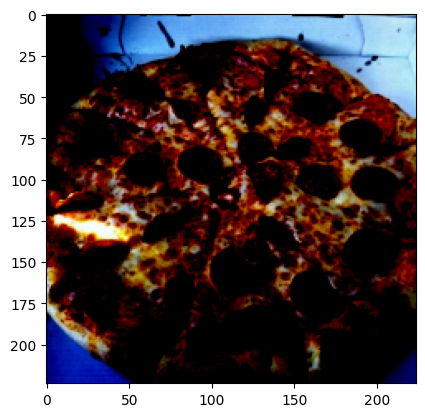

In [5]:
imagen, label = training_dataset[0]
img_tensor = imagen.permute(1,2,0)
imagen = img_tensor.numpy()

plt.imshow(imagen)

In [6]:

class ResNet50ForMNIST(nn.Module):
    def __init__(self):
        super(ResNet50ForMNIST, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)
         
    def forward(self, x):
        return self.base_model(x)

# Instanciar el modelo
model = ResNet50ForMNIST().to(device)

c:\Users\Genia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Genia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Definir el criterio de pérdida y el optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [8]:
def plot_loss(losses):
    epochs = range(1, len(losses) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, losses, label="Training Loss", color="blue", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

def plot_accuracy(accuracies):
    epochs = range(1, len(accuracies) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, accuracies, label="Test Accuracy", color="green", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy Over Epochs")
    plt.legend()
    plt.show()

In [9]:
# Función para entrenar el modelo
import matplotlib.pyplot as plt
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            labels = labels.view(-1, 1).float()
            images, labels = images.to(device), labels.to(device)
            
            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward y optimización
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)

        # Calcular la precisión promedio por época y agregarla a la lista
        accuracy = 100 * correct / total
        epoch_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    plot_loss(epoch_losses)
    plot_accuracy(epoch_accuracies)
        
        
# Función para evaluar el modelo
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.view(-1, 1).float()
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total

    print(f"Test Accuracy: {accuracy:.2f}%")

    return accuracy


Epoch 1/5, Loss: 0.5100
Epoch 2/5, Loss: 0.3472
Epoch 3/5, Loss: 0.3144
Epoch 4/5, Loss: 0.2912
Epoch 5/5, Loss: 0.2607


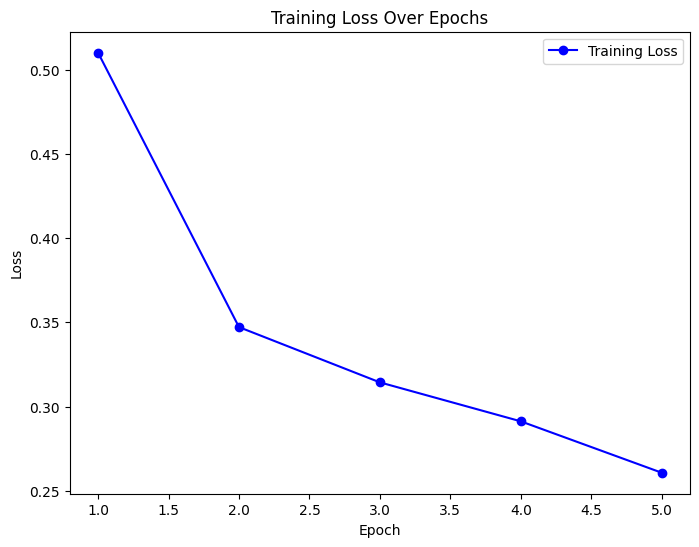

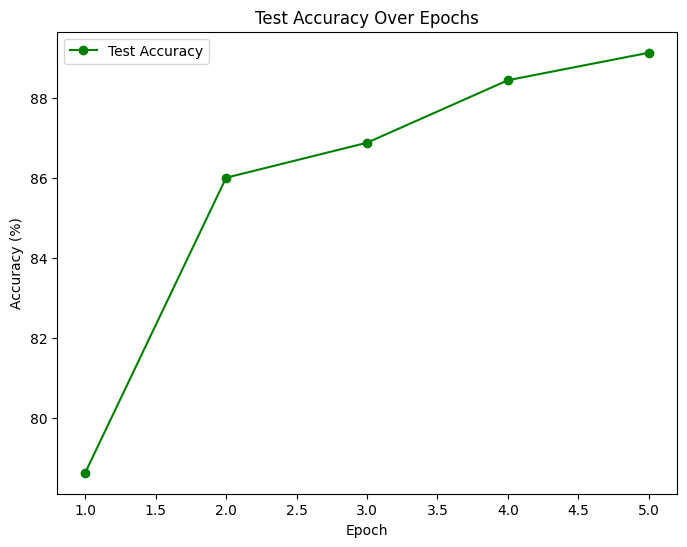

Test Accuracy: 89.89%


89.89071038251366

In [10]:

# Entrenar y evaluar el modelo
train_model(model, training_loader, criterion, optimizer, num_epochs=5)
evaluate_model(model, test_loader)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar imágenes junto con sus etiquetas
def plot_predictions(model, test_loader, num_images=10):
    model.eval()
    images_class_0 = 0
    images_class_1 = 0
    target_class = num_images // 2  # Imágenes por clase
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for i in range(images.size(0)):
                # Mostrar solo si aún no hemos alcanzado el número deseado por clase
                if images_class_0 >= target_class and images_class_1 >= target_class:
                    break

                # Convertir la imagen tensorial a formato de imagen para graficar
                img = images[i].cpu().numpy()
                img = np.transpose(img, (1, 2, 0))  # Reordenar canales para visualización
                img = (img * 0.5) + 0.5  # Desnormalizar
                
                if labels[i].item() == 0 and images_class_0 < target_class:
                    plt.subplot(1, num_images, images_class_0 + images_class_1 + 1)
                    plt.imshow(img, cmap="gray")
                    plt.title(f"True: {labels[i].item()}\nPred: {predictions[i].item()}")
                    plt.axis("off")
                    images_class_0 += 1

                elif labels[i].item() == 1 and images_class_1 < target_class:
                    plt.subplot(1, num_images, images_class_0 + images_class_1 + 1)
                    plt.imshow(img, cmap="gray")
                    plt.title(f"True: {labels[i].item()}\nPred: {predictions[i].item()}")
                    plt.axis("off")
                    images_class_1 += 1

            if images_class_0 >= target_class and images_class_1 >= target_class:
                break

    plt.tight_layout()
    plt.show()



def plot_predictions_miss(model, test_loader, num_images=10):
    model.eval()
    images_class_0 = 0
    images_class_1 = 0
    target_class = num_images // 2  # Imágenes por clase
    plt.figure(figsize=(15, 5))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).squeeze().long()

            for i in range(images.size(0)):
                # Mostrar solo si aún no hemos alcanzado el número deseado por clase
                if images_class_0 >= target_class and images_class_1 >= target_class:
                    break

                # Mostrar solo las imágenes mal clasificadas
                if predicted[i] != labels[i]:
                    # Convertir la imagen tensorial a formato de imagen para graficar
                    img = images[i].cpu().numpy()
                    img = np.transpose(img, (1, 2, 0))  # Reordenar canales para visualización
                    
                    img = (img * 0.5) + 0.5  # Desnormalizar
                    img = np.clip(img, 0, 1)  # Asegurarse de que los valores estén entre 0 y 1

                    if labels[i].item() == 0 and images_class_0 < target_class:
                        plt.subplot(1, num_images, images_class_0 + images_class_1 + 1)
                        plt.imshow(img)
                        plt.title(f"True: {labels[i].item()}\nPred: {predicted[i].item()}")
                        plt.axis("off")
                        images_class_0 += 1

                    elif labels[i].item() == 1 and images_class_1 < target_class:
                        plt.subplot(1, num_images, images_class_0 + images_class_1 + 1)
                        plt.imshow(img)
                        plt.title(f"True: {labels[i].item()}\nPred: {predicted[i].item()}")
                        plt.axis("off")
                        images_class_1 += 1

            if images_class_0 >= target_class and images_class_1 >= target_class:
                break

    plt.tight_layout()
    plt.show()





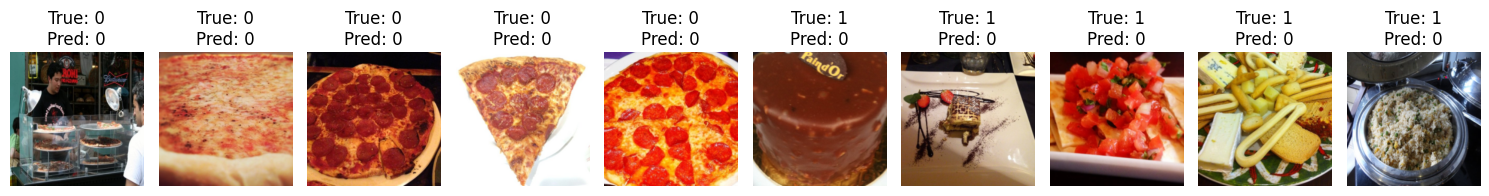

In [12]:
# Llamar a la función después de entrenar el modelo
plot_predictions(model, test_loader, num_images=10)

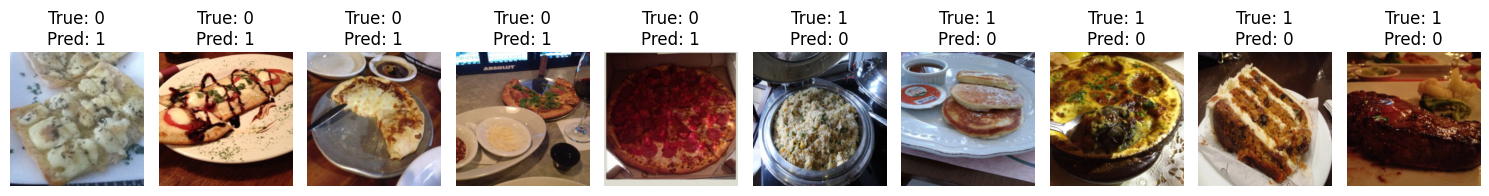

In [13]:
plot_predictions_miss(model, test_loader, num_images=10)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

# Listas para almacenar etiquetas y predicciones
all_labels = []
all_predictions = []

# Pasar por el test_loader
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Obtener las predicciones del modelo
        outputs = model(images)
        predictions = (torch.sigmoid(outputs) > 0.5).squeeze().long()

        # Almacenar las etiquetas verdaderas y predicciones
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Calcular e imprimir el informe de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_predictions))

# Calcular e imprimir la matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       183
           1       0.93      0.86      0.90       183

    accuracy                           0.90       366
   macro avg       0.90      0.90      0.90       366
weighted avg       0.90      0.90      0.90       366

Confusion Matrix:
[[171  12]
 [ 25 158]]


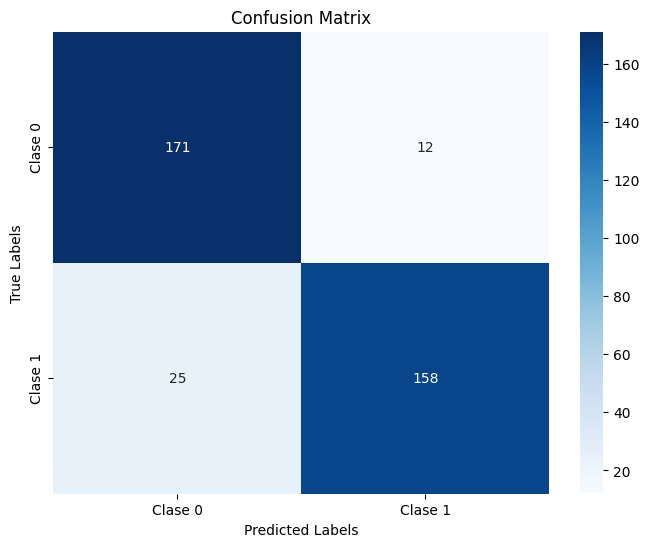

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_predictions)

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear un mapa de calor para la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])

# Etiquetas y título
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
